In [309]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)


### Playing around with using different columns that are complete

In [313]:
train = pd.read_csv('../data/clean_train_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")  
test = pd.read_csv('../data/clean_test_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")
locales = pd.read_csv('../data/okurg_chase.csv')
gold = pd.read_csv('../data/gold_district.csv')
raw = pd.read_csv('../../data/train.csv',parse_dates=['timestamp'])

In [314]:
# get the cols that in both
tr_cols = train.columns.tolist()
te_cols = test.columns.tolist()
cols = set(tr_cols).intersection(te_cols)

In [315]:
# train = train[train.timestamp>'2013-01-01']

In [316]:
train_index = train.index.tolist()
test_index = test.index.tolist()

cols = ['life_sq','full_sq','floor','max_floor','kitch_sq','product_type',
        'sub_area','kremlin_km','price_doc','timestamp']

test['price_doc'] = np.nan

df = pd.concat([train[cols].copy(),
                test[cols].copy()],
               ignore_index=False)

df['month'] = df.timestamp.dt.month.astype(object)

In [317]:
df = pd.merge(df,locales[['sub_area','okurg_district']],how="left",on='sub_area').reset_index(drop=True).set_index(df.index)

In [318]:
gold.set_index('month_year',inplace=True)

In [319]:
# gold.reset_index(inplace=True)

In [320]:

# gold.columns = ['period','month_year','nominal_index']
# macro['month_year'] = pd.PeriodIndex(macro['month_year'], freq='M').strftime('%m/%y')
df['month_year'] = pd.PeriodIndex(df['timestamp'], freq='M').strftime('%m/%y')

# df = pd.merge(df,gold[['month_year','nominal_index','period']], how="left", on="month_year").reset_index(drop=True).set_index(df.index)

In [321]:
gold_dict = gold.to_dict()

In [322]:
def get_index(df):
    return gold_dict[df.okurg_district][df.month_year]

In [323]:
temp = df[['month_year','okurg_district']]

In [324]:
# temp = df[['month_year','okurg_district']]

# for row in temp.iterrows():
#     row_id = row[0]
#     district = row[1][1]
#     month_year = row[1][0]
#     temp.loc[row_id,'nominal_index'] = gold_dict[district][month_year]

In [336]:
gold.head()

,eastern,northeastern,northern,northwestern,outside,southeastern,southern,southwestern,western,zelenograd,central
month_year,,,,,,,,,,,
08/11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
09/11,0.987471,1.051406,1.005089,1.051406,1.051406,0.995682,1.005089,0.987471,0.947449,1.051406,1.0
10/11,0.999380,1.046138,1.056757,1.046138,1.046138,0.998270,1.056757,0.999380,0.935578,1.046138,1.0
11/11,1.064449,1.040038,1.051462,1.040038,1.040038,0.945810,1.051462,1.064449,0.946861,1.040038,1.0
12/11,1.052047,0.995274,1.045331,0.995274,0.995274,0.933960,1.045331,1.052047,1.008511,0.995274,1.0


In [337]:
gold.loc['08/11','eastern']

1.0

In [338]:
df.timestamp.min()

Timestamp('2011-08-20 00:00:00')

In [341]:
temp['nominal_index'] = temp.apply(lambda x:  gold.loc[x[0],x[1]], axis=1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [343]:
df['nominal_index'] = temp.nominal_index

In [344]:
# rent_index = pd.read_csv('../data/rent_3room_index.csv',header=None)
# rent_index.columns = ['month_year','nominal_index']
# # macro['month_year'] = pd.PeriodIndex(macro['month_year'], freq='M').strftime('%m/%y')
# df['month_year'] = pd.PeriodIndex(df['timestamp'], freq='M').strftime('%m/%y')

# df = pd.merge(df,macro[['month_year','nominal_index']], how="left", on="month_year").reset_index(drop=True).set_index(df.index)

In [345]:
df.sub_area = df.sub_area.apply(lambda x: x.replace(" ", "_"))
df.sub_area = df.sub_area.apply(lambda x: x.replace("'", ""))
df.sub_area = df.sub_area.apply(lambda x: x.replace("-", ""))

In [346]:
df['kitch_to_life'] = df.kitch_sq / df.life_sq
df['life_to_full'] = df.life_sq / df.full_sq
df['bld_type'] = 'med_rise'
df.loc[df.max_floor <= 5,'bld_type'] = 'low_rise'
df.loc[df.max_floor >= 17,'bld_type'] = 'high_rise'
df['walk_up_penalty'] = 0
df.loc[(df.floor>4) & (df.max_floor < 6),'walk_up_penalty'] = 1 

In [347]:
# df['price_doc'] = df.price_doc / df.nominal_index
df['price_full'] = df.price_doc / df.full_sq

## dropping outliers
outliers = df[df.price_full < 30000].copy()
df.drop(outliers.index,axis=0, inplace=True)
for x in outliers.index.tolist():
    train_index.remove(x)

df['log_price'] = np.log(df.price_doc)
df['log_price_full'] = np.log(df.price_full)
# df['price_doc'] = df.price_doc / 1000


In [348]:
len(train)

29096

In [349]:
len(train_index)

29096

### Multiple Linear Regression

In [350]:
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score

ols = linear_model.LinearRegression()

# cols to drop
# drop_cols = ['timestamp','price_doc','nominal_index','adj_price_doc','price_full','log_price','price_full']
cols = ['full_sq','floor','sub_area','kremlin_km','month','nominal_index']
lm_data = df[cols].copy()

df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])


dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

x_train = df_all.loc[train_index]

y_train = df.loc[train_index,'log_price_full']

x_test = df_all.loc[test_index,:]

ols.fit(x_train,y_train)
print('R^2: %.2f' % ols.score(x_train, y_train))
# df.log_price

R^2: 0.37


In [351]:
# df.loc[test_index,'price_doc'] = ols.predict(x_test) * df.loc[test_index,'full_sq'] * df.loc[test_index,'nominal_index']
df.loc[test_index,'price_doc'] = np.exp(ols.predict(x_test)) * df.loc[test_index,'full_sq'] #* df.loc[test_index,'nominal_index']
# df.sort_values('price_full',ascending=False)

In [352]:
cols = ['price_doc','full_sq','price_full']
sub = df.loc[test_index,cols]
sub['price_full'] = sub.price_doc / sub.full_sq

147562.48896


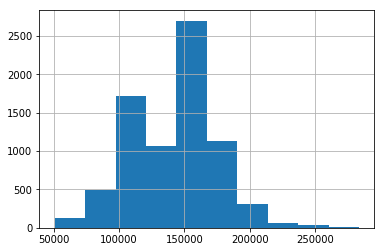

In [353]:
print sub.price_full.median()
sub.price_full.hist()

In [355]:
# kaggle score 0.33776
sub['price_doc'].to_frame().to_csv('../submissions/simple_linear_gold_0530_330PM.csv')

## Minmax scaled

In [225]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
pipe  =  make_pipeline(MinMaxScaler(), linear_model.LinearRegression())


cols = ['full_sq','floor','sub_area','kremlin_km','month']
lm_data = df[cols].copy()

df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])


dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

x_train = df_all.loc[train_index]

y_train = df.loc[train_index,'price_full']

x_test = df_all.loc[test_index,:]

param_grid = {}
grid =  GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_train, y_train)

print grid.score(x_train,y_train)

0.499236383113


In [226]:
df.loc[test_index,'price_doc'] = grid.predict(x_test) * df.loc[test_index,'full_sq'] * df.loc[test_index,'nominal_index']

In [227]:
cols = ['price_doc','full_sq','price_full']
sub = df.loc[test_index,cols]
sub['price_full'] = sub.price_doc / sub.full_sq

In [243]:
sub.loc[38110,'price_doc'] = sub.loc[38110,'full_sq'] * 75000
sub.loc[33708,'price_doc'] = sub.loc[33708,'full_sq'] * 75000

In [244]:
sub.sort_values('price_full')

,price_doc,full_sq,price_full
id,,,
33708,3.322500e+06,44.30,-9.970153e+15
38110,4.342500e+06,57.90,-9.746333e+15
34127,3.030451e+06,69.42,4.365386e+04
33475,3.030451e+06,69.42,4.365386e+04
31944,3.183490e+06,69.42,4.585840e+04
35905,2.941465e+06,63.80,4.610446e+04
32897,3.120363e+06,67.12,4.648932e+04
32819,3.120363e+06,67.12,4.648932e+04
33571,2.382456e+06,51.20,4.653235e+04


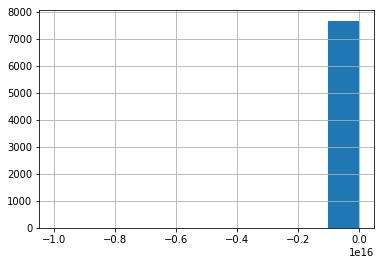

In [232]:
sub.price_full.hist()

## Looking at stats

In [93]:
cols = ['price_full','product_type','full_sq','floor','kremlin_km','sub_area','month']
lm_data = df.loc[train_index,cols].copy()

df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

In [94]:
all_columns = "+".join(df_all.columns[1:-1])

In [95]:
model = sm.ols(formula ='price_full ~ ' + all_columns, data = df_all)
fitted = model.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:             price_full   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     259.1
Date:                Sat, 27 May 2017   Prob (F-statistic):               0.00
Time:                        18:48:17   Log-Likelihood:            -3.1863e+05
No. Observations:               27566   AIC:                         6.376e+05
Df Residuals:                   27407   BIC:                         6.389e+05
Df Model:                         158                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

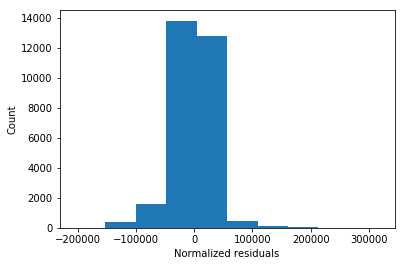

In [25]:
plt.hist(fitted.resid)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [26]:
influence = fitted.get_influence()
#c is the distance and p is p-value
x = pd.DataFrame({'c' :influence.cooks_distance[0], 'p': influence.cooks_distance[1]})
x.sort_values('c')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/stats/outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,c,p
27074,6.755241e-16,1.000000e+00
19202,1.010253e-13,1.000000e+00
28939,3.003961e-13,1.000000e+00
28055,6.280352e-13,1.000000e+00
22834,1.004671e-12,1.000000e+00
3763,1.196070e-12,1.000000e+00
2446,1.314402e-12,1.000000e+00
28637,1.369680e-12,1.000000e+00
23538,1.856176e-12,1.000000e+00
5537,2.159125e-12,1.000000e+00


In [ ]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(fitted)
influence_plot(fitted)

In [20]:
cols = ['price_doc','full_sq','sub_area','kremlin_km','price_full']
df.loc[27096,cols]

price_doc               8439.36
full_sq                      55
sub_area      Nagatinskij_Zaton
kremlin_km              8.05738
price_full              153.443
Name: 27096, dtype: object

456.50076120743444

In [53]:
cv_scores = cross_val_score(ols, x_train, y_train, cv=10)
print cv_scores

[ 0.42788215  0.55501799  0.5988087   0.5554951   0.54050592  0.55748369
  0.55827505  0.61427153  0.57239928  0.61094148]


In [54]:
ols.predict(x_test)

array([ 15.26927389,  15.76154285,  15.32017376, ...,  15.15358656,
        15.2948478 ,  15.72791287])

In [55]:
cv_scores = cross_val_score(ols, x_train, y_train, cv=10)
print cv_scores

[ 0.42788215  0.55501799  0.5988087   0.5554951   0.54050592  0.55748369
  0.55827505  0.61427153  0.57239928  0.61094148]


In [47]:
test1 = pd.DataFrame({'price_doc': ols.predict(x_test)},index=test_index)

In [48]:
test['price_doc'] = ols.predict(x_test)

In [56]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


pipe  =  make_pipeline(MinMaxScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(pipe, param_grid, cv=5)
lm_predictions = grid.fit(x_train, y_train)

In [57]:
# print lm_predictions.predict(x_train)
print lm_predictions.best_score_

0.55986024025


In [ ]:
from sklearn import preprocessing 

In [ ]:
np.exp(log_y_test)

In [58]:
cols = ['timestamp','price_doc','nominal_index','adj_price_doc','price_full','log_price','price_full']

pipe  =  make_pipeline(MinMaxScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [59]:
sub = grid.predict(x_test)

In [60]:
sub = pd.DataFrame({'id': test_index, 'price_doc':sub})

In [61]:
sub.loc[:,'nominal_index'] = df.loc[test_index,'nominal_index'].values

In [66]:
'%f' % 1.128899e+08

'112889900.000000'

In [62]:
sub.price_doc = sub.price_doc * sub.nominal_index

In [63]:
sub.loc[:,'price_doc'].to_frame().to_csv('../Chase/submissions/052617_linear_ridge_regression.csv')

In [64]:
sub.sort_values('price_doc')

,id,price_doc,nominal_index
6938,37412,16.722780,1.162486
7654,38128,16.795930,1.162486
5143,35617,16.865221,1.173957
6092,36566,16.874353,1.173957
5422,35896,16.875906,1.173957
4552,35026,16.875906,1.173957
5166,35640,16.875906,1.173957
4112,34586,16.877455,1.173957
5638,36112,16.879989,1.173957
4617,35091,16.887796,1.173957


In [237]:
# df.loc[test_index,'nominal_index']

In [247]:
sub.head()

,id,price_doc,nominal_index
0,30474,4.176246e+06,1.214295
1,30475,9.594552e+06,1.214295
2,30476,5.235794e+06,1.214295
3,30477,9.846788e+06,1.214295
4,30478,2.628036e+06,1.214295
